In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-09-24 08:07:33,554 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

# paths_train = glob('../submit/lb9516/*_train.gz')
# paths_test  = glob('../submit/lb9516/*_test.gz')
# paths_train += glob('../feature/raw_use/is*_train.gz')
# paths_test  += glob('../feature/raw_use/is*_test.gz')
# paths_train += glob('../feature/raw_use/TransactionID_train.gz')
# paths_test  += glob('../feature/raw_use/TransactionID_test.gz')
# paths_train = glob('../submit/sub_valid/*_train.gz')
# paths_test  = glob('../submit/sub_valid/*_test.gz')
paths_train = glob('../submit/re_sub/*_train.gz')
paths_test  = glob('../submit/re_sub/*_test.gz')
paths_train += glob('../submit/add_feature/*_train.gz')
paths_test  += glob('../submit/add_feature/*_test.gz')
paths_train += glob('../feature/valid_use/531*_train.gz')
paths_test  += glob('../feature/valid_use/531*_test.gz')
paths_train += glob('../feature/valid_use/532*_train.gz')
paths_test  += glob('../feature/valid_use/532*_test.gz')
paths_train += glob('../feature/valid_trush/528*uid2*_train.gz')
paths_test  += glob('../feature/valid_trush/528*uid2*_test.gz')

# for path in paths_train:
#     if path.count('C14_ratio'):
#         paths_train.remove(path)
        
# for path in paths_test:
#     if path.count('C14_ratio'):
#         paths_test.remove(path)
    
# paths_train = glob('../feature/raw_use/*_train.gz')
# paths_test = glob('../feature/raw_use/*_test.gz')
# paths_train = [path for path in paths_train if filter_feature(path) ]
# paths_test = [path for path in paths_test if filter_feature(path) ]

# paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/kernel/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/kernel/*_test.gz'))

# paths_train_feature = sorted(glob('../feature/valid_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/valid_use/*_test.gz'))
paths_train_feature = []
paths_test_feature  = []

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

In [3]:
# xdeep = pd.read_csv('../output/pred_result/20190923_1646_ieee__xdeepfm_pred_1041feature_AUC0-870').iloc[:, 1:]
# df_train = df_train.merge(xdeep, how='inner', on=COLUMN_ID)
# df_test = df_test.merge(xdeep, how='inner', on=COLUMN_ID)
# df_user_id_bear = pd.read_csv('../output/same_user_pattern/20190901_user_ids_share.csv').set_index(COLUMN_ID)

# df_train.set_index(COLUMN_ID, inplace=True)
# df_train['user_id_bear'] = df_user_id_bear['predicted_user_id']
# df_train.reset_index(inplace=True)

# df_test.set_index(COLUMN_ID, inplace=True)
# df_test['user_id_bear'] = df_user_id_bear['predicted_user_id']
# df_test.reset_index(inplace=True)

2019-09-24 08:08:27,157 func.utils 111 [INFO]    [<module>] * EXP: dataset new_set (590540, 1256) lr 0.01  


  * Diff Features: 0
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.908541
[400]	valid_0's auc: 0.921856
[600]	valid_0's auc: 0.927825
[800]	valid_0's auc: 0.931297
[1000]	valid_0's auc: 0.933127
[1200]	valid_0's auc: 0.934206
[1400]	valid_0's auc: 0.935034
[1600]	valid_0's auc: 0.935506
[1800]	valid_0's auc: 0.935642
Early stopping, best iteration is:
[1835]	valid_0's auc: 0.935699


2019-09-24 08:15:21,751 func.utils 140 [INFO]    [ieee_cv]   * Fold0 2017-12: 0.9356992002908255 | Bear's...PB:0.9811527576710176 PV:0.9795213820348105 All:0.9799609597948261 


[  * Fold0 Validation-DT-M 2017-12: 134339] done in 404 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.939818
[400]	valid_0's auc: 0.950244
[600]	valid_0's auc: 0.954741
[800]	valid_0's auc: 0.956672
[1000]	valid_0's auc: 0.957471
[1200]	valid_0's auc: 0.957664
Early stopping, best iteration is:
[1227]	valid_0's auc: 0.957699


2019-09-24 08:19:33,109 func.utils 140 [INFO]    [ieee_cv]   * Fold1 2018-3: 0.9576990572908664 | Bear's...PB:0.9692624873371944 PV:0.9744583007343113 All:0.9727451280224972 


[  * Fold1 Validation-DT-M 2018-3: 101968] done in 246 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.936246
[400]	valid_0's auc: 0.950063
[600]	valid_0's auc: 0.955745
[800]	valid_0's auc: 0.958425
[1000]	valid_0's auc: 0.959583
[1200]	valid_0's auc: 0.960522
[1400]	valid_0's auc: 0.961236
[1600]	valid_0's auc: 0.961754
[1800]	valid_0's auc: 0.96185
[2000]	valid_0's auc: 0.962094
[2200]	valid_0's auc: 0.962172
Early stopping, best iteration is:
[2102]	valid_0's auc: 0.962229
[  * Fold2 Validation-DT-M 2018-1: 92510] done in 489 s


2019-09-24 08:27:48,359 func.utils 140 [INFO]    [ieee_cv]   * Fold2 2018-1: 0.962229375781443 | Bear's...PB:0.9838379255919899 PV:0.9800678176606591 All:0.9813497676433759 


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.933661
[400]	valid_0's auc: 0.944449
[600]	valid_0's auc: 0.949193
[800]	valid_0's auc: 0.951289
[1000]	valid_0's auc: 0.952196
[1200]	valid_0's auc: 0.952749
[1400]	valid_0's auc: 0.953089
[1600]	valid_0's auc: 0.953133
Early stopping, best iteration is:
[1503]	valid_0's auc: 0.953245


2019-09-24 08:33:38,505 func.utils 140 [INFO]    [ieee_cv]   * Fold3 2018-5: 0.9532450329028024 | Bear's...PB:0.9413859076782026 PV:0.9417905721873915 All:0.9421531266704091 


[  * Fold3 Validation-DT-M 2018-5: 92427] done in 344 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.949891
[400]	valid_0's auc: 0.958975
[600]	valid_0's auc: 0.962704
[800]	valid_0's auc: 0.964251
[1000]	valid_0's auc: 0.964943
[1200]	valid_0's auc: 0.965374
[1400]	valid_0's auc: 0.965657
[1600]	valid_0's auc: 0.965883
[1800]	valid_0's auc: 0.966102
[2000]	valid_0's auc: 0.966262
[2200]	valid_0's auc: 0.966344
[2400]	valid_0's auc: 0.966488
[2600]	valid_0's auc: 0.966608
[2800]	valid_0's auc: 0.966674
Early stopping, best iteration is:
[2722]	valid_0's auc: 0.96674


2019-09-24 08:43:53,771 func.utils 140 [INFO]    [ieee_cv]   * Fold4 2018-2: 0.9667404719428844 | Bear's...PB:0.9820862127731336 PV:0.9805396994691769 All:0.980879118889195 


[  * Fold4 Validation-DT-M 2018-2: 85725] done in 610 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.946424
[400]	valid_0's auc: 0.95908
[600]	valid_0's auc: 0.964333
[800]	valid_0's auc: 0.966808
[1000]	valid_0's auc: 0.967914
[1200]	valid_0's auc: 0.968505
[1400]	valid_0's auc: 0.968962
[1600]	valid_0's auc: 0.969201
Early stopping, best iteration is:
[1604]	valid_0's auc: 0.96921


2019-09-24 08:49:31,959 func.utils 140 [INFO]    [ieee_cv]   * Fold5 2018-4: 0.9692096210968818 | Bear's...PB:0.9725319553984226 PV:0.9648136680828968 All:0.9673805370392354 


[  * Fold5 Validation-DT-M 2018-4: 83571] done in 332 s
[  * Make Prediction Result File.] done in 48 s
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9515 / 0.001862022737109423
  *  (506691,) (506691,)
  * LB0.9545 / 0.9615223854857696
  *  (506691,) (506691,)
  * LB0.9561 / 0.9341864211917528
* CV: 0.9574704598842839 | BestIter: 1832.1666666666665
* Training Feature Importance


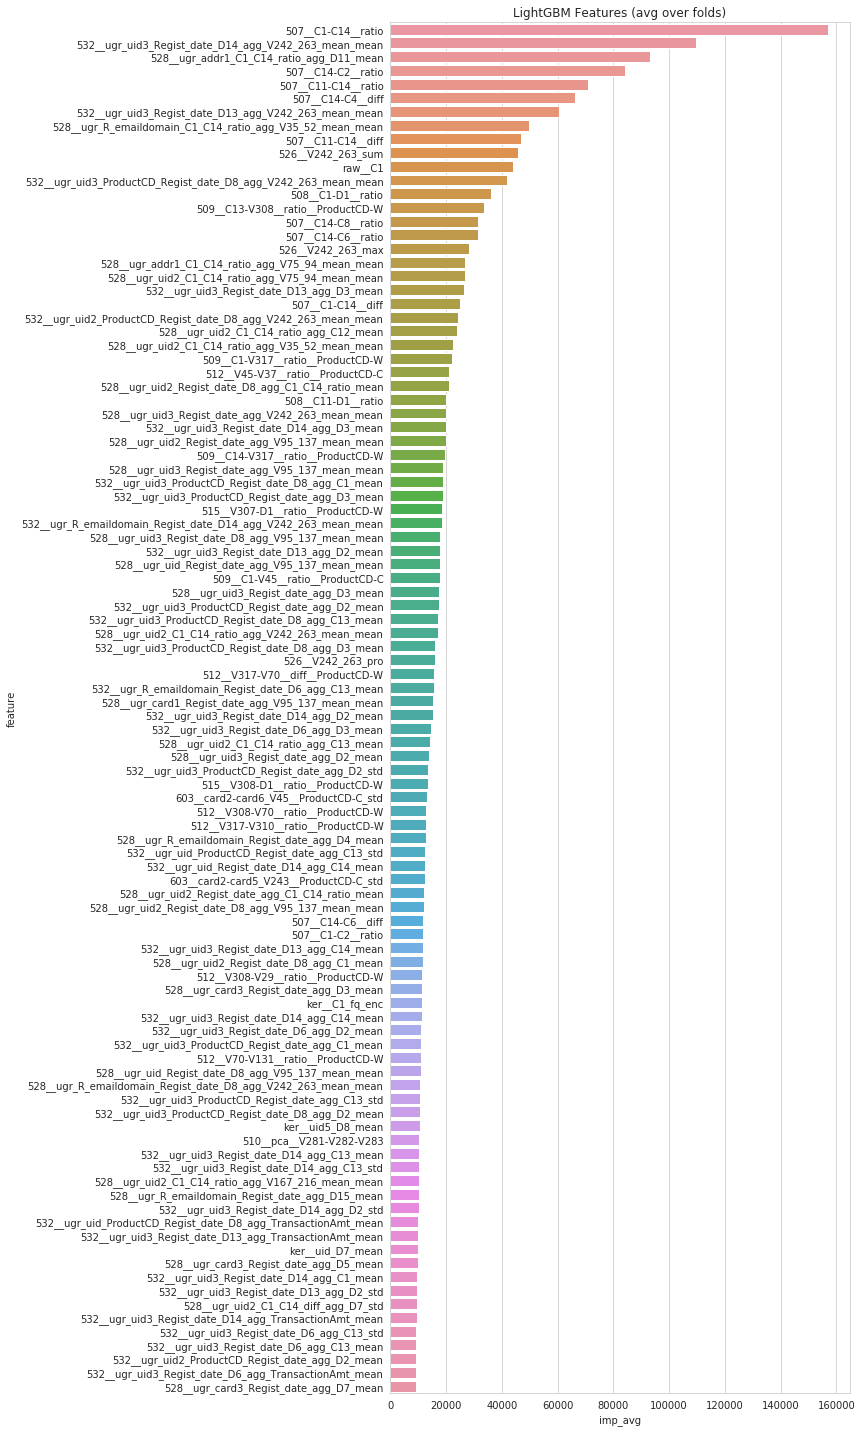

Setup Dataset dim_ml_dataset.


In [4]:
is_submit = [True, False][0]
has_dec = [True, False][0]
n_splits = 6
set_type = 'new_set'

valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

if len(valid_paths_train):
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
else:
    tmp_train = df_train
    tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group

# 2017-12抜いてみる
# if not has_dec:
#     tmp_train = tmp_train[tmp_train[COLUMN_GROUP]!='2017-12']
#     Y = Y.loc[tmp_train.index]
#     n_splits = 5


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 60,
    'n_jobs': 96,
#     'n_jobs': 84,
#     'n_jobs': 48,
#     'n_jobs': 36,
    'objective': 'binary',
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 0.10,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
    'n_splits': n_splits,
    'metric': 'auc',
    'model_type': model_type,
    'fold': ['stratified', 'group'][1],
}
if is_submit:
    params['learning_rate'] = 0.01
#     params['learning_rate'] = 0.05
    params["early_stopping_rounds"] = 100

logger.info(f"* EXP: dataset {set_type} {tmp_train.shape} lr {params['learning_rate']} ")

list_result_feim = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)
feim = list_result_feim[0]

In [5]:
feim = list_result_feim[0]
# feim = read_pkl_gzip('../output/feature_importances/20190922_0227__CV0-953443367765578__feature1142.gz')
key1 = '532_'
key2 = ''
idx = [col for col in feim.index if col.count(key1) and col.count(key2)]
# feim = feim.loc[idx]
feim.tail(50)

,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_fold6,imp_avg
feature,,,,,,,
512__V308-V127__diff__ProductCD-R,898.095276,1024.793457,640.494568,986.030029,1350.349854,1095.639893,999.233887
512__V310-V312__diff__ProductCD-W,831.617859,907.685547,902.559204,1247.455444,896.653870,1161.148804,991.186829
532__ugr_uid3_Regist_date_D6_agg_D12_mean,1074.038818,632.349426,1185.379028,874.563354,1120.385620,1010.687317,982.900635
512__V258-V78__diff__ProductCD-C,873.384521,819.168274,990.500061,950.687134,955.130920,1269.396240,976.377747
raw__P_emaildomain_anonymous_com_dummie,869.837708,1202.700562,613.625061,1145.862061,868.383789,965.333191,944.290344
526__V95_137_pro,681.373108,869.352539,870.855469,936.453613,1319.051147,866.526062,923.935303
ker__V243,564.549500,724.034241,1158.454102,543.366272,1294.455688,1232.244507,919.517395
532__ugr_uid3_Regist_date_D15_agg_C4_std,864.691711,890.506836,1326.720947,727.263916,694.172241,1001.252502,917.434631
514__D8__ProductCD-H,949.655334,843.210876,789.555847,1052.822876,1010.547668,854.872009,916.777527


In [18]:
# feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
# for feature_name in feim[feim['imp_avg']<1000].index:
for feature_name in feim[feim['imp_avg']<200].index:
    
#     if not feature_name.count('532__'):
#         continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
#     from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'raw_use'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
    from_dir = '../submit/re_sub'
    from_dir = '../submit/add_feature/'
#     from_dir = 'org_use'
#     from_dir = 'valid_use'
    to_dir = '../submit/escape'
#     to_dir = 'valid_trush'
#     to_dir = 'raw_trush'
#     to_dir = 'check_trush'
#     to_dir = 'org_use'
#     to_dir = 'useless'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
        print(feature_name)
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)

603__card2-card5_V243__ProductCD-W_std
516__P_emaildomain_suffix_com_dummie
532__ugr_uid3_Regist_date_D15_agg_D15_std
532__ugr_uid3_ProductCD_Regist_date_D8_agg_C3_mean
ker__C3_fq_enc
526__V2_11_pro
526__V3_4_5_9_11_max
516__P_emaildomain_suffix_us_dummie
526__V2_11_max
526__V3_4_5_9_11_pro
516__R_emaildomain__isnull
516__P_emaildomain_suffix_nan_dummie
516__R_emaildomain_suffix_mx_dummie
512__V83-V318__diff__ProductCD-R
516__P_emaildomain__isnull
518__cnt__M4__ProductCD-C
532__ugr_uid3_ProductCD_Regist_date_D8_agg_D13_std
raw__R_emaildomain_mail_com_dummie
526__V167_216_pro
516__R_emaildomain_suffix_nan_dummie
532__ugr_uid3_ProductCD_Regist_date_D8_agg_D9_std
526__V35_52_pro
603__addr2_V258__ProductCD-H_sum
532__ugr_uid3_Regist_date_D14_agg_D14_std
532__ugr_uid3_ProductCD_Regist_date_D8_agg_C3_std
532__ugr_uid3_ProductCD_Regist_date_D8_agg_D8_std
532__ugr_uid3_Regist_date_D6_agg_D6_std
512__V38-V281__diff__ProductCD-R
532__ugr_uid3_Regist_date_D13_agg_D13_std
532__ugr_uid3_Regist_date

In [11]:
# sub = pd.read_csv('../submit/lb/20190909_2324__CV0-9467296784440689__feature552.csv')
# sub = pd.read_csv('../submit/lb/20190917_0022__CV0-947676__BearAUC0-9631.csv')
# sub = pd.read_csv('../submit/tmp/20190917_0825__CV0-9486992730843505__feature750.csv')
# sub = pd.read_csv('../submit/tmp/20190917_0947__CV0-9454660522014052__feature750.csv')
# sub = pd.read_csv('../submit/tmp/20190917_1107__CV0-9485055333319241__feature686.csv')
sub = pd.read_csv('../submit/tmp/20190920_1002__CV0-9505750228407942__feature994.csv')
sub[COLUMN_ID] = sub[COLUMN_ID].astype('int')
sub.head()

,TransactionID,isFraud
0,3663549,0.000495
1,3663550,0.000919
2,3663551,0.000627
3,3663552,0.000943
4,3663553,0.000530


In [12]:
from sklearn.metrics import roc_auc_score
bear = pd.read_csv('../input/20190913_ieee__bear_probing.csv').iloc[:, [0, 3, 4, 6]]
bear = bear[bear[COLUMN_TARGET]==-1]
bear = bear.iloc[:, [0,1,3]]
sub.columns = [COLUMN_ID, 'pred']
bear.columns = [COLUMN_ID, 'data_type', COLUMN_TARGET]
bear_score = sub.merge(bear, how='inner', on=COLUMN_ID)
public = bear_score[bear_score['data_type']=='test_public']
private = bear_score[bear_score['data_type']=='test_private']


public_score = roc_auc_score(public[COLUMN_TARGET].values, public['pred'].values)
private_score = roc_auc_score(private[COLUMN_TARGET].values, private['pred'].values)
all_score = roc_auc_score(bear_score[COLUMN_TARGET].values, bear_score['pred'].values)
print(public_score, private_score, all_score)

0.9693337434518601 0.9597681288570636 0.9637032059110936


In [2]:
feim = read_pkl_gzip('../output/feature_importances/20190920_1351__CV0-9534658757641309__feature1190.gz')
# pd.set_option('max_rows', 200)
# feim = list_result_feim[0]
print(feim.shape)
# idx = [idx for idx in feim.index if idx.count('522_')]
# feim = feim.loc[idx]
feim.tail(50)
# feim.loc[[i for i in feim.index if i.count('browser')]]

(1190, 7)


,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_fold6,imp_avg
feature,,,,,,,
ker__V242,47.774681,4.338970,157.266205,25.605141,16.049654,41.456802,48.748577
526__V226_230_max,22.176426,55.315231,53.842461,34.148781,29.509571,95.777603,48.461674
526__V3_4_5_9_11_std,37.532028,50.733662,95.086105,12.702540,42.304096,50.577877,48.156052
526__V35_52_sum,52.651798,61.228378,20.721521,21.287121,56.446484,75.927711,48.043839
515__V281-D7__ratio__ProductCD-C,18.076248,44.716400,58.564159,120.377441,11.641709,33.174541,47.758419
ker__C7_fq_enc,41.392582,18.879320,8.857655,124.174248,47.684486,40.963020,46.991882
526__V2_11_std,36.242226,45.175713,43.775230,10.490940,59.599934,60.088589,42.562107
526__V53_74_pro,41.066399,9.237090,35.865799,100.957336,0.000000,32.664398,36.631836
516__P_emaildomain_bin_anonymous_dummie,10.870800,82.834084,54.781380,0.000000,45.428070,2.191230,32.684261


In [9]:
feim[feim['imp_avg']<2000].shape

(688, 7)